In [1]:
# tensorflow: 2.2.0, numpy: 1.21.6, pandas: 1.3.5, matplotlib: 3.2.2

In [2]:
import numpy as np
import pandas as pd
import datetime
import random
import pickle

import time as tim
from IPython.display import clear_output
import copy


In [3]:
# 한시간 간격으로 전체 bss에서 호출 나머지는 1과 동일

In [4]:
# # 피클 저장, 로드
# # save
# with open('data.pickle', 'wb') as f:
#     pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

# # load
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)


In [5]:
day_n = 10

bike_n = 300
D_size = 42*bike_n*10


qrate = 0.99
exploration_rate = 0.01
max_w_i = 1
beta = 0.4
beta_zero = 1

base_freq=[1.526, 6.256, 7.91, 6.541, 5.402, 5.005, 5.919, 10.07, 15.597, 15.458, 11.61, 8.707]# 주문발생빈도 쌍봉형
day_avg = [60, 56, 52, 48, 44, 40, 35, 31, 27, 23] # 하루 평균 주문건수 n그룹
char_rule=[30, 24, 20, 15, 10] # 배터리 교환 규칙

fit_count=0

time_char_rule=[]

bss_n = 30 # 고정
interval_sigma = 300 # 배달간격 표준편차 (초단위)
dist_sigma = 300 # 미터단위 배달거리의 표준편차
velo = 25000/3600 # 이륜차 평균속도
velo_sigma = 2 # 이륜차 속도의 표준편차
gene_hyper = 3100
bat_max_wh = 1850 # 배터리 1팩 기준 wh / 1 cycle => 247 감소
bat_max_dist = 35000 # 한 팩 당 총 이동거리
bat_somo = bat_max_wh/bat_max_dist
cycle_loss = 0.247
best_episode_reward=0
TD_error_list=np.array([])
TD_max=1
epsilon = 0.0001

delivery_reward = 10000
n_sample = 48

history = []
pred_ub = []
pred_lb = []

In [6]:
# from keras.callbacks import Callback
# class CustomHistory(Callback):
#     def init(self):
#         self.losses = []
#         self.vol_losses = []
#         self.accs = []
#         self.vol_accs = []

#     def on_epoch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))
# #         self.vol_losses.append(logs.get('vol_loss'))
# #         self.accs.append(logs.get('acc'))
# #         self.vol_accs.append(logs.get('acc_loss'))

## CNN

In [8]:
# 계속 멀티프로세스를 써서 속도가 느려져서 해결하려고 한 흔적.. 버전문제인 것으로 사료되나 우선 남겨둠.
import os
import tensorflow as tf
num_threads = 1
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)

In [9]:
############ CNN
from tensorflow.keras import backend as K
from tensorflow.keras.backend import expand_dims
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling1D,Reshape,Embedding, LSTM, Dense,Embedding, concatenate, LSTM,Conv1D, MaxPooling1D, Flatten, Dropout, Lambda, BatchNormalization, Activation

from tensorflow.keras import optimizers
from tensorflow.keras import Input

from tensorflow.keras.optimizers import Adam

# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

def make_model():

    def custom_loss(y_true, y_pred):

        c = tf.math.multiply(y_pred, y_true)
        d = tf.math.square(c)
        out = tf.math.reduce_mean(d, axis=None)
        # out =  tf.math.square(tf.math.multiply(tf.math.add(y_pred, tf.math.negative(delta)), y_true))
        return out
    # 딥러닝 모델
    #         시간(1), 좌표(2), 충전량(1), 충전소별 큐 길이(30), 충전소별잔여 배터리량(180)
    delta = Input(shape=(1,))
    mask = Input(shape=(2,))

    important_state = Input(shape=(34,),name='important_state')

    bss_state = Input(shape=(120,),name='bss_state')

    other_bike_state = Input(shape=(1,),name='other_bike_state')


    concatenated = concatenate([important_state,bss_state,other_bike_state])

    # concatenated = Lambda(lambda x: K.expand_dims(x,axis=2))(concatenated)
    concatenated = tf.keras.layers.Reshape((155, 1), input_shape = (155,))(concatenated)


    x = Conv1D(filters=32,kernel_size=4, strides=1, activation = 'relu')(concatenated)
    x = Conv1D(filters=64,kernel_size=4, strides=1, activation = 'relu')(x)
    x = Conv1D(filters=64,kernel_size=4, strides=1, activation = 'relu')(x)
    x1 = Conv1D(filters=2,kernel_size=4, strides=1, activation = 'relu')(x)
    x1 = Flatten()(x1)
#         x = concatenate([x,important_state])

    x1 = Dense(50,activation='relu')(x1)
    x2 = Conv1D(filters=2,kernel_size=4, strides=1, activation = 'relu')(x)
    x2 = Flatten()(x2)
    x2 = Dense(50,activation='relu')(x2)

    advantage = Dense(2)(x1)
    value = Dense(1)(x2)

    policy = Lambda(lambda x: x[0]-K.mean(x[0],keepdims=True)+x[1])([advantage, value])
    policy = Lambda(lambda x: x[0]+x[1])([policy, mask])
    a = tf.math.negative(delta)
    b = tf.math.add(policy, a)


    model = Model([important_state,bss_state,other_bike_state, mask],[policy])
    train_model = Model([important_state,bss_state,other_bike_state,mask,delta],[b])
    train_model.compile(optimizer = Adam(learning_rate=0.00005), loss=[custom_loss])

    # # opti =  RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

    model.compile(optimizer='rmsprop',loss=['mse'])
    return model, train_model
model, train_model = make_model()
model2, train_model2 = make_model()

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
important_state (InputLayer)    [(None, 34)]         0                                            
__________________________________________________________________________________________________
bss_state (InputLayer)          [(None, 120)]        0                                            
__________________________________________________________________________________________________
other_bike_state (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 155)          0           important_state[0][0]            
                                                                 bss_state[0][0]              

2022-09-16 16:48:07.714533: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-09-16 16:48:07.736432: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3187200000 Hz
2022-09-16 16:48:07.736555: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d11a12a570 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-16 16:48:07.736565: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [10]:
# train_model.fit([np.array([np.ones(34)]),np.array([np.ones(120)]),np.array([np.ones(1)]),np.array([np.ones(2)]),np.array([np.ones(1)])],[np.array([np.append(np.zeros(1),0)])])

In [11]:
from tensorflow.keras.models import load_model

def model_fit():
    global fit_count, model2, beta
#         시간(1), 좌표(2), 충전량(1), 충전소별 큐 길이(30), 충전소별잔여 배터리량(180)

#     if fit_count%10000==0:
#         if fit_count < 1000000:
#             print('model updated')
#             model2.set_weights(model.get_weights())
#         if fit_count%100000==0:
#             with open('D_memory(230).pickle', 'wb') as f:
#                 pickle.dump(D_memory, f)
#             with open('D_terminal.pickle', 'wb') as f:
#                 pickle.dump(D_terminal, f)

#         print('model updated')
    global best_episode_reward
#         fit_count += 1
# #         model2 = load_model('best_model.h5')
# #         model2.compile(optimizer='rmsprop',loss=['mse'])
#         model2.set_weights(model.get_weights())
#         best_episode_reward=0
    if fit_count%8==0:
        if (len(D_memory)>1000):
            train_x = []
            train_y = []
            cur_states_1=[]
            cur_states_2=[]
            cur_states_3=[]
            cur_states_mask=[]
            cur_states_delt=[]

            fu_states_1=[]
            fu_states_2=[]
            fu_states_3=[]
            fu_states_mask=[]
            fu_states_delt=[]

            temp=[]
            sample_weight=[]

            choices = random.choices(TD_index, weights = TD_error_list, k = n_sample)

            for choice in choices:
                # 비복원추출
                train=D_memory[choice]

                cur_states_1.append(train[0][0:34])
                cur_states_2.append(train[0][34:154])
                cur_states_3.append(train[0][154:155])
                mask = masking(train[0])
                cur_states_mask.append(mask)

                fu_states_1.append(train[3][0:34])
                fu_states_2.append(train[3][34:154])
                fu_states_3.append(train[3][154:155])
                mask = masking(train[3])
                fu_states_mask.append(mask)

            predict_x=[np.array(fu_states_1),np.array(fu_states_2),np.array(fu_states_3),np.array(fu_states_mask)]

            predicted_2 = model2.predict(predict_x, verbose = 0)
            predicted_1 = model.predict(predict_x, verbose = 0)


            for i, choice in enumerate(choices):

                train=D_memory[choice]

                predicted = predicted_2[i][np.argmax(predicted_1[i].copy())]

                tmp_max = qrate*predicted

                tmp=np.zeros(2)
                tmp[train[1]]=1.0

                temp.append(tmp)

                w_i = ((len(D_memory)*TD_error_list[choice]/np.sum(TD_error_list))**(-beta))/max_w_i

                sample_weight.append(w_i)

                cur_states_delt.append((train[2] + tmp_max*(1-train[4])))

                TD_error_list[choice] = np.abs(train[2] + tmp_max*(1-train[4])-predicted_1[i][train[1]]) + epsilon

            train_y=[np.array(temp)]
            train_x=[np.array(cur_states_1),np.array(cur_states_2),np.array(cur_states_3),np.array(cur_states_mask),np.array(cur_states_delt)]
            sample_weight = np.asarray(sample_weight)
            # with tf.device('/device:CPU:0'):
            train_model.fit(train_x,train_y, verbose=0, sample_weight = sample_weight, workers=1, use_multiprocessing=False)

            beta = beta_zero + (1-beta_zero)*(fit_count/1000000)
            if beta > 1:
                beta = 1
#         elif len(D_sparse_order)<2:
#             D_sparse_order.append(D_often_order[0])

#     fit_count +=1


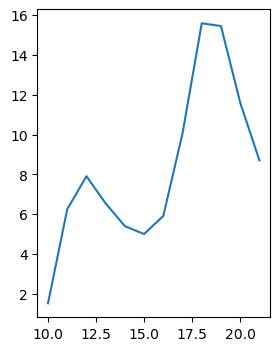

In [13]:
import matplotlib.pyplot as plt
#          10 11 12 13 14 15 16 17 18 19 20 21
# base_freq=[2, 10,13,12, 5, 2, 2,10,16,16,9, 3]
plt.figure(figsize=(3, 4))
plt.plot(range(10,22),base_freq)
plt.show()

In [14]:
def update_memory(s1,a,r,s2,time):
#     print(a, r, time)
    global fit_count, episode_reward, D_often, D_sparse, TD_error_list, TD_index, TD_max, terminal
    fit_count +=1
    if fit_count%10000==0:
        temp = []
        for i in range(len(initial_states)):
            tmp=[]
            tmp.append(np.array([initial_states[i][0:34]]))
            tmp.append(np.array([initial_states[i][34:154]]))
            tmp.append(np.array([initial_states[i][154:184]]))
            mask = masking(initial_states[i])
            tmp.append(np.array([mask]))
            # with tf.device('/device:CPU:0'):
            predicted1 = model.predict(tmp, verbose=0).copy()
            temp.append(np.max(predicted1))
        history.append(np.mean(temp))
        pred_ub.append(np.max(temp))
        pred_lb.append(np.min(temp))
        plt.title('Average Q at Initial')
        plt.plot(np.arange(1,len(history)+1),history)
        plt.fill_between(np.arange(1,len(history)+1),pred_ub, pred_lb, color = 'k', alpha = 0.1)
        plt.show()
        if fit_count < 1000000:
            print('model updated')
            model2.set_weights(model.get_weights())
        if fit_count%100000==0:
            with open('D_memory(210).pickle', 'wb') as f:
                pickle.dump(D_memory, f)

    if tmp_terminal == False:

        r = r/(delivery_reward)
        episode_reward += r

        if time<=43200:

            D_memory.append([s1, a, r, s2,0])

        elif time>43200:
            D_memory.append([s1, a, r, s2,1])

        if len(D_memory)>D_size:
                D_memory.pop(0)

    elif tmp_terminal == True:

        r = r/(delivery_reward)
        episode_reward += r

        D_memory.append([s1, a, r, s2,1])

        if len(D_memory)>D_size:
                D_memory.pop(0)

    TD_error = TD_max
    if len(TD_error_list)<D_size:
        TD_index = np.arange(0,len(TD_error_list)+1)
    else:

        TD_error_list = np.delete(TD_error_list,0)
    TD_error_list = np.append(TD_error_list, TD_error)


In [15]:
# 일초기화에서 위치, status, bat, charge_num, order_freq, order_list, order

class Bike():
    def __init__(self):
        self.key=0
        self.cur_time = 0
        self.loc = (0,0)
        self.fu_loc = (0,0)
        self.ploc=(0,0)
        self.status = 'daegi'
        self.bat = [0,1]
        self.charge_count = 0
        self.order_freq = 2
        self.acc_dist=0
        self.order_list = []
        self.bss_list=[] # [충전소로 출발하는 시간, 충전소 도착할시간, 충전소index, 충전소로 출발할 때 오토바이 위치]
        self.order_count = 0
        self.charge_rule = 50
        self.sooneung = 100
        self.cur_state=[]
        self.action=0
        self.reward=0
        self.fu_state=np.ones(155)
        self.moving_queue_time = 0
        self.stay_queue_time = 0
        self.daegi = True
  
        self.history = [[self.status, self.cur_time, self.loc, self.acc_dist, self.bat, self.charge_count, self.order_count]] # 
        self.moving_queue = 0 # time
    def __lt__(self, other):
        return self.key < other.key
    
    def decide(self):
        
        self.ploc = self.loc
        global event_list, state, fubike_idx, exploration_rate
        event_list.pop(0)

#         현주문빈도(1), 다음주문빈도(1), 배터리(1), 시간(1), 충전소까지거리(30), 큐길이, 충전량(120), 타밬정보(1)
        cur_state=[]
        # 현재 시간 주문빈도
        if time < 43200:
            cur_state.append(base_freq[int(time/3600)]/16)
        else:
            cur_state.append(base_freq[-1]/16)
        # 다음 시간 주문 빈도
        if int(time/3600) >=11:
            cur_state.append(base_freq[-1]/16)
        # 일종료시점이면 현재시간으로
        else:
            cur_state.append(base_freq[int(time/3600)+1]/16)
        # 본인 배터리 용량
        cur_state.append(battery[self.bat[0]].soc/100)
        # 시간
        cur_state.append(time/43200)
        for i in range(len(bss)):
            # 각 bss 까지의 상대거리 (30)
            cur_state.append(distance(self.loc, bss[i].loc)/5000)


        # bss 정보(90)
        for i in range(len(bss)):
            # 충전소별 큐 길이 (30)
            cur_state.append(len(bss[i].queue)/3)
            # 충전소별 배터리 충전량 (높은 순)(90)
            tmp=[]
            for j in range(2,8,1):
                battery[bss[i].slot[j]].bat_charge()
            for j in range(2,8,2):
                tmp.append(battery[bss[i].slot[j]].soc)
            tmp = sorted(tmp,reverse = True)
            for j in range(len(tmp)):
                cur_state.append(tmp[j]/100)

        # 다른 바이크 정보 (배터리)(1)
        count=0
        for i in range(len(bike)):
            if battery[bike[i].bat[0]].soc < 50:
                count +=1
        cur_state.append(count)
        self.fu_state = copy.deepcopy(cur_state)
        if self.daegi ==False:
            update_memory(self.cur_state, self.action, self.reward, self.fu_state, time)
        self.daegi = False
        
        self.reward = 0
        self.cur_state = copy.deepcopy(cur_state)

        model_fit()

        fubike_idx = self.key
        if exploration_rate < 0.01:
            exploration_rate = 0.01
        if random.randint(0,100)/100<1-exploration_rate:
            tmp=[]
            tmp.append(np.array([cur_state[0:34]]))
            tmp.append(np.array([cur_state[34:154]]))
            tmp.append(np.array([cur_state[154:155]]))
            mask = masking(cur_state)
            tmp.append(np.array([mask]))
            # with tf.device('/device:CPU:0'):
            qvalue = model.predict(tmp, verbose=0)
            action = np.argmax(qvalue)
#             print('action: ',action)
#             print(cur_state[34+action], cur_state[64+action*3:64+action*3+3])
#             print(mask)
#             print(qvalue)
        else:
            mask = masking(cur_state)
            aa=False
            count = 0
            while aa==False:
                count += 1
                action = random.randint(0,1)
                if mask[action]==0:
                    aa=True
                if count > 50:
                    aa=True
                    action = 1
#             print('action: ',action)
#             print(mask)
        self.action = action

        if time < 43200:
            if action==1:
                event_list.insert(0,[time, self, 'order_generate'])
            else:     
                # tmp: 가까운 순 정렬
                tmp = []
                for i in range(len(bss)):
                    tmp.append([distance(self.loc, bss[i].loc), i])
                tmp = sorted(tmp)

                action = len(bss)+1
                # 가까운 순 정렬된거로 for문 돌리면서, 교체가능 배터리 있으면 글루 ㄱㄱ, break
                k=0
                while action ==len(bss)+1:
                    for i in range(len(bss)):
                        idx = tmp[i][1]

                        tmp_bss=[]
                        for j in range(2,8,1):
                            battery[bss[idx].slot[j]].bat_charge()
                        for j in range(2,8,2):
                            tmp_bss.append(-battery[bss[idx].slot[j]].soc)
                        tmp_bss = sorted(tmp_bss)
                        if len(bss[idx].queue) < 3:
                            if -tmp_bss[len(bss[idx].queue)] > 95-k:
                                action = idx
    #                             print(1, action)
                                break
                    k+=1
                    if k > 50:
                        action = random.randint(0,29)
                event_list.insert(0,[time, self, 'go_bss',action])

    def order_generate(self):
        global event_list
#         self.status='daegi'
        time_dae = int(time/3600)
        if time > 43200:
            time_dae = 11
        interval = gene_hyper/self.order_freq[time_dae]
        gen_inter = np.random.normal(interval,interval_sigma)    
        while gen_inter < 0:
            gen_inter = np.random.normal(interval,interval_sigma)
        if time_dae != (time+gen_inter)//3600:
            if time_dae != 11:
                interval = gene_hyper/((self.order_freq[time_dae]+self.order_freq[time_dae+1])/2)
            gen_inter = np.random.normal(interval,interval_sigma)
            while gen_inter < 0:
                gen_inter = np.random.normal(interval,interval_sigma)
        max_dist = distance((0,0), self.loc)

        tt=False
        while tt==False:
            gen_dist = np.random.normal(2400,dist_sigma)
            while (gen_dist > 3465)|(gen_dist <max_dist):
                gen_dist = np.random.normal(2400,dist_sigma)

            food_list=[]
            for i in range(len(food_loc)):
                if distance(food_loc[i],self.loc) < gen_dist:
                    food_list.append(i)
            idx = food_list[np.random.randint(len(food_list))]

            x=np.random.random()
            theta = np.random.random()*2*np.pi
            r=gen_dist - distance(food_loc[idx],self.loc)
            house_loc = (food_loc[idx][0]+r*np.cos(theta), food_loc[idx][1]+r*np.sin(theta))

            tt=discri(house_loc)

        tmp_time = gen_inter + time
        self.fu_loc = food_loc[idx]
        event_list.pop(0)
        pickuptime = distance(food_loc[idx],self.loc)/velo
        if tmp_time < 43200:
            if tmp_time - pickuptime <time:
                self.status = 'pickup'
            else:
                for i in range(len(event_list)):
                    if event_list[i][0] > tmp_time-pickuptime:
                        event_list.insert(i,[tmp_time-pickuptime, self, 'change_status_pickup'])
                        break
                    elif i == len(event_list)-1 :
                        event_list.append([tmp_time-pickuptime, self, 'change_status_pickup'])

            for i in range(len(event_list)):
                if event_list[i][0] > tmp_time:
                    event_list.insert(i,[tmp_time, self, 'pickup'])
                    break
                if i == (len(event_list)-1):
                    event_list.append([tmp_time, self, 'pickup'])

            self.order_list.append([tmp_time, food_loc[idx], house_loc, self.loc])
        else:
#             self.terminal = True
            self.reward += delivery_reward
            update_memory(self.cur_state, self.action, self.reward, self.fu_state, 1000000)

    def pickup(self):
        global event_list
        order = self.order_list[len(self.order_list)-1]

        self.status='delivery'
        self.cur_time= time
        self.loc=order[1]
        self.acc_dist=self.acc_dist+ distance(order[3], order[1])
        self.history.append([self.status, self.cur_time, self.loc, self.acc_dist, self.bat, self.charge_count, self.order_count])
    #     self.soc=self.soc-(self.dist(self.order_list[3], self.order_list[1])/2*bat_somo/bat_max_dist
        tmp_velo = np.random.normal(velo,velo_sigma)
        while (tmp_velo > velo*1.2)|(tmp_velo <velo*0.8):
            tmp_velo = np.random.normal(velo,velo_sigma)
      
        tmp_time = time + distance(order[1],order[2])/tmp_velo
        self.fu_loc = order[2]
        event_list.pop(0)
        battery[self.bat[0]].bat_consume()
        battery[self.bat[1]].bat_consume()
        
        for i in range(len(event_list)):
            if event_list[i][0] > tmp_time:
                event_list.insert(i, [tmp_time, self, 'delivery'])
                break        
            if i == (len(event_list)-1):
                event_list.append([tmp_time, self, 'delivery'])   
    def change_status_pickup(self):
        self.status = 'pickup'
        event_list.pop(0)

        
    def delivery(self):
        global event_list
        
        self.ploc = self.loc
        order = self.order_list[len(self.order_list)-1]
        self.status='delivery'
        self.cur_time= time
        self.loc=order[2]
        self.order_count=self.order_count+1
        self.acc_dist=self.acc_dist+ distance(order[1], order[2])
        self.history.append([self.status, self.cur_time, self.loc, self.acc_dist, self.bat, self.charge_count, self.order_count])
        battery[self.bat[0]].bat_consume()
        battery[self.bat[1]].bat_consume()
        
#         self.reward += delivery_reward
        
        

        
#         print(round(time,1),round(battery[self.bat[0]].soc,1),round(battery[self.bat[1]].soc,1))
        if battery[self.bat[0]].soc < 0:
            global terminal, tmp_terminal
#             bike[self.bik].reward = bike[self.bik].reward -2000
            print('oring occured')
            print('day start to termianl : %.1f'%time)
            terminal = True
            tmp_terminal = True
             
            update_memory(self.cur_state, self.action, self.reward, self.fu_state, 1000000)
           
#         else:
#             update_memory(self.cur_state, self.action, self.reward, self.fu_state, time)          

        event_list.pop(0)
        event_list.insert(0, [time, self, 'decide'])
 


    def go_bss(self,tmp_idx):
        global event_list
        if self.status=='queue':
            self.reward = self.reward-10000
        if len(bss[tmp_idx].queue)>=3:
            self.reward = self.reward-delivery_reward
        self.status='go_bss'

        tmp_velo = np.random.normal(velo,velo_sigma)
        while (tmp_velo > velo*1.2)|(tmp_velo <velo*0.8):
            tmp_velo = np.random.normal(velo,velo_sigma)

        tmp_dist = distance(bss[tmp_idx].loc, self.loc)
        tmp_time = time + tmp_dist/tmp_velo
        self.fu_loc = bss[tmp_idx].loc

        self.bss_list.append([time, tmp_time, tmp_idx, self.loc])



        if tmp_time <=43200: 
            if int(tmp_time/3600)==int(time/3600):
                self.reward = self.reward - (tmp_time-time)*base_freq[int(tmp_time/3600)]
            else:
                if tmp_time <=43200: 
                    self.reward = self.reward - (int(tmp_time/3600)*3600-time)*base_freq[int(time/3600)] - (tmp_time-int(tmp_time/3600)*3600)*base_freq[int(tmp_time/3600)]

        self.moving_queue_time += tmp_time-time
        event_list.pop(0)

        for i in range(len(event_list)):
            if event_list[i][0]>tmp_time:
                event_list.insert(i,[tmp_time, self, 'arrived_bss', tmp_idx])
                break
            elif i == len(event_list)-1 :
                event_list.append([tmp_time, self, 'arrived_bss', tmp_idx])
        bss[tmp_idx].queue.append([tmp_time,self.key])
#         bss[tmp_idx].queue = sorted(bss[tmp_idx].queue)

        
    def arrived_bss(self,tmp_idx):
        ######큐 추가#####
        global episode_reward, event_list
        
        
        
        self.status='queue'
        self.cur_time = time
        tmp_bss = self.bss_list[-1]
        
        
        self.acc_dist = self.acc_dist + distance(self.loc, bss[tmp_idx].loc)
        self.loc = bss[tmp_idx].loc
        self.history.append([self.status, self.cur_time, self.loc, self.acc_dist, self.bat, self.charge_count, self.order_count])
                    
        battery[self.bat[0]].bat_consume()
        battery[self.bat[1]].bat_consume() 

#         print(round(time,1),round(battery[self.bat[0]].soc,1),round(battery[self.bat[1]].soc,1))


#         cur_state=[]
#         cur_state.append(time/43200)
#         cur_state.append(self.loc[0]/3000)
#         cur_state.append(self.loc[1]/3000)
#         cur_state.append(battery[self.bat[0]].soc/100)
#         for i in range(len(bss)):
#             cur_state.append(len(bss[i].queue)/3)
#         for i in range(len(bss)):
#             for j in range(2,8,2):
#                 battery[bss[i].slot[j]].bat_charge()
#                 cur_state.append(battery[bss[i].slot[j]].soc/100)
#         self.fu_state = cur_state
#         self.fu_state = copy.deepcopy(state)
        if battery[self.bat[0]].soc < 0:
            global terminal, tmp_terminal
#             bike[self.bik].reward = bike[self.bik].reward -2000
            print('oring occured')
            print('day start to termianl : %.1f'%time)
            terminal = True
            tmp_terminal = True

             
            update_memory(self.cur_state, self.action, self.reward, self.fu_state, 1000000)
         

#         print(self.reward, battery[self.bat[0]].soc)
        
        
        
        event_list.pop(0)
        tmp=False
        for i in range(len(event_list)):
            if (event_list[i][1]== bss[tmp_idx])&(event_list[i][2]=='swap'):
                tmp=True
                break
        if tmp==False:    
            event_list.insert(0, [time+0.00001, bss[tmp_idx], 'swap'])
        
        bss[tmp_idx].count += 1



In [16]:
class Bss():
    def __init__(self):
        self.key=0
        self.queue = []
        self.loc = (0,0)
        self.slot = [None, None, 2,3,4,5,6,7]
        self.bss_history=[]
        self.min_his = []
        self.count=0

    def __lt__(self, other):
        return self.key < other.key

    def swap(self):
        global event_list
#         [status, time, bike[i] or bss[i], self.soc, charge_count]
        for i in range(6):
            idx = i+2
            bat_idx = self.slot[idx]
            battery[bat_idx].bat_charge()

#         if len(self.queue)>1: # 큐 이미 있으면 패스
#             event_list.pop(0)
#         else: #교환가능한거 있으면 교환, 없으면 대기
        tmp_soc = 10
        idx_list=[]
        if len(self.queue)<1:
            event_list.pop(0)
        elif self.queue[0][0]+0.0001>=time:
            event_list.pop(0)

            event_list.insert(0,[self.queue[0][0]+0.001, self, 'swap'])
            event_list = sorted(event_list)

        else:
            for i in range(6):
                idx = i+2
                if tmp_soc*0.99 <= battery[self.slot[idx]].soc:
                    tmp_soc = battery[self.slot[idx]].soc
                    idx_list.insert(0,idx)

            if tmp_soc >= 95:
                bike_idx = self.queue[0][1] # 바이크 인덱스
                idx_list# 배터리 슬롯 인덱스(앞에잇을수록 용량 많음)
                bike_bat = [bike[self.queue[0][1]].bat[0], bike[self.queue[0][1]].bat[1]]#넣은배터리index 2 리스트형
                bat_idx = [self.slot[idx_list[0]],self.slot[idx_list[1]]] # 뺀배터리 index 2 리스트형
                #히스토리업데이트
                #[bike index, bike 도착시간, bike나가는시간, 배터리슬롯index, 넣은배터리index, 뺀배터리index]
                self.bss_history.append([bike_idx, self.queue[0][0], time, [idx_list[0],idx_list[1]], bike_bat, bat_idx])
                #교환
#                 print(self.queue[0][0], time)
                arrived_time = self.queue[0][0]
                self.min_his.append([self.key, bike_idx,day, self.queue[0][0], time - self.queue[0][0]])


                if int((time+60)/3600) == int(arrived_time/3600):
                    if arrived_time > 43200:
                        bike[bike_idx].reward = delivery_reward
                    else:
                        bike[bike_idx].reward = bike[bike_idx].reward - ((time - arrived_time)+60)*base_freq[int((time+60)/3600)]
                else:
                    if time+60 <= 43200:
                        bike[bike_idx].reward = bike[bike_idx].reward - (int((time+60)/3600)*3600-arrived_time)*base_freq[int(arrived_time/3600)] - (time+60 - int((time+60)/3600)*3600)*base_freq[int((time+60)/3600)]
                    else:
                        bike[bike_idx].reward = bike[bike_idx].reward - (int((time+60)/3600)*3600-arrived_time)*base_freq[int(arrived_time/3600)-1] - (43200 - int((time+60)/3600)*3600)*base_freq[-1]

                
                bike[bike_idx].stay_queue_time += time - self.queue[0][0]

#                     global terminal, tmp_terminal
#                     tmp_terminal = True
                if time + 60 < 43200:
                    daegitime = time+60 - self.queue[0][0]
                else:
                    daegitime = 43200 - self.queue[0][0]
                if daegitime >3600:
                    global terminal
                    terminal = True
                    print('so long waited in ', self.key)
                    print('day start to termianl : %.1f'%time)

                self.slot[idx_list[0]]= bike_bat[0]
                self.slot[idx_list[1]]= bike_bat[1]
                
                bike[bike_idx].bat = bat_idx
                bike[bike_idx].charge_count += 1
                bike[bike_idx].history.append([bike[bike_idx].status, time, bike[bike_idx].loc, bike[bike_idx].acc_dist, bike[bike_idx].bat, bike[bike_idx].charge_count, bike[bike_idx].order_count])
                battery[bat_idx[0]].bik= bike_idx
                battery[bat_idx[0]].bss= None
                battery[bat_idx[0]].charge_count +=1 
                battery[bat_idx[1]].bik= bike_idx
                battery[bat_idx[1]].charge_count +=1
                battery[bat_idx[1]].bss= None
                battery[bat_idx[0]].status='on_bike'
                battery[bat_idx[0]].time = time
                battery[bat_idx[1]].time = time
                battery[bat_idx[1]].status='on_bike'
                battery[bat_idx[0]].bat_history.append([battery[bat_idx[0]].status, time, battery[bat_idx[0]].soc,battery[bat_idx[0]].bik,  battery[bat_idx[0]].charge_count])
                battery[bat_idx[1]].bat_history.append([battery[bat_idx[1]].status, time,battery[bat_idx[1]].soc, battery[bat_idx[1]].bik,  battery[bat_idx[1]].charge_count])

                battery[bike_bat[0]].bss = self.key
                battery[bike_bat[0]].status = 'charge'
                battery[bike_bat[0]].time = time
                battery[bike_bat[1]].time = time
                battery[bike_bat[1]].status = 'charge'
                battery[bike_bat[1]].bss = self.key
                battery[bike_bat[0]].bat_history.append([battery[bike_bat[0]].status, time, battery[bike_bat[0]].soc,battery[bike_bat[0]].bik,  battery[bike_bat[0]].charge_count])
                battery[bike_bat[1]].bat_history.append([battery[bike_bat[1]].status, time, battery[bike_bat[1]].soc,battery[bike_bat[1]].bik,  battery[bike_bat[1]].charge_count])


                event_list.pop(0)
                event_list.insert(0,[time+0.01, self, 'swap'])
                event_list.insert(0,[time+60, bike[bike_idx], 'decide'])
                event_list = sorted(event_list)
                self.queue.pop(0)
                if (daegitime >1800)|(time > 43200):
                    update_memory(bike[bike_idx].cur_state, bike[bike_idx].action, bike[bike_idx].reward, bike[bike_idx].fu_state, 50000)
                    bike[bike_idx].daegi = True

            else:

                tmp_time = time + (99.5-tmp_soc)*72
                event_list.pop(0)
    
                event_list.append([tmp_time, self, 'swap'])  
                event_list = sorted(event_list)



In [17]:
class Battery():
    
    def __init__(self):
        self.key=0
        self.so=100
        self.bat_acc=0
        self.status='charge' # 'charge'<100% / 'full'=100% / 'on_bike'
        self.soc=100 # float
        self.bik=0 # bike에 인덱싱
        self.bss=0 # bss에 인덱싱
        self.time=0
        self.cycle=0 # 방전횟수
        self.max_charge=100
        self.charge_count=0 # int
        self.bat_history=[['on_bike', 0, 100, 0, 0]] # [status, time, bike[i] or bss[i], self.soc, charge_count]
        
    def __lt__(self, other):
        return self.key < other.key
        
    def bat_consume(self):
        self.status = 'on_bike'
        global terminal

        loc0=bike[self.bik].history[-1][2]
        loc1=bike[self.bik].history[-2][2]
        self.so = self.so - distance(loc0, loc1)/2*bat_somo/bat_max_wh*100
        self.soc = self.so*100/self.max_charge
        self.bat_history.append([self.status, time,self.soc, self.bik, self.charge_count])
#         if (self.soc < 25)&(self.soc>0):
#             if (bike[self.bik].status=='daegi')|(bike[self.bik].status=='pickup')|(bike[self.bik].status=='delivery'):
#                 bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
#                 if self.soc < 20:
#                     bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
#                 if self.soc < 15:
#                     bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
#                 if self.soc < 12:
#                     bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
#                 if self.soc < 9:
#                     bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
#                 if self.soc < 6:
#                     bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
#                 if self.soc < 3:
#                     bike[self.bik].reward = bike[self.bik].reward - (delivery_reward/5)
            
            

        
        
        if self.soc < 0:
            bike[self.bik].reward = bike[self.bik].reward - (delivery_reward*3)
#             print('day start to termianl : %.1f'%time, end = ' ')
#             terminal = True
#             print('god', end='')
             
#             update_memory(bike[self.bik].cur_state, bike[self.bik].action, bike[self.bik].reward, bike[self.bik].cur_state, 1000000)

    
#             model_fit()

            
            


    def bat_charge(self):
        self.status='charge'
        if len(self.bat_history)!=0:


            self.bat_acc+=(time-self.bat_history[-1][1])/72
            self.cycle= self.bat_acc/100
#             self.max_charge=100-(cycle_loss*self.cycle)
            
            self.so = self.so + (time-self.bat_history[-1][1])/72
            if self.so > self.max_charge:
                self.so = self.max_charge
            self.soc = self.so*100/self.max_charge
            
            self.bat_history.append([self.status, time, self.soc, self.bik, self.charge_count])    


<function matplotlib.pyplot.show(*args, **kw)>

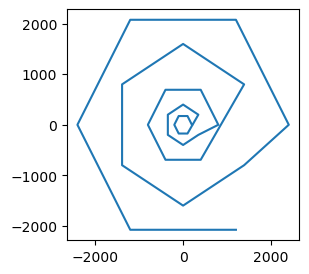

In [18]:
# 충전소 위치
bss_loc=[]
bss_r = [200,400,800,1600,2400]
for j in range(len(bss_r)): # 거리
    for i in range(6): # 각도
        if j%2==0:
            theta = np.pi*i/3
            bss_loc.append((bss_r[j]*np.cos(theta),bss_r[j]*np.sin(theta)))
        if j%2==1:
            theta = np.pi*i/3 + np.pi/6
            bss_loc.append((bss_r[j]*np.cos(theta),bss_r[j]*np.sin(theta)))
df =pd.DataFrame(bss_loc)
plt.figure(figsize=(3, 3))
plt.plot(df[0],df[1])
plt.show


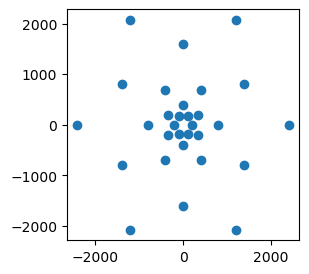

In [19]:
plt.figure(figsize=(3, 3))
plt.scatter(df[0],df[1])
plt.show()

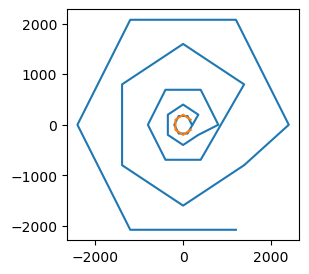

In [20]:
# # 음식점 위치 생성
# food_loc=[]
# n=30 # 음식점 개수
# r=1500
# #반지름 2km 원 위에 고르게 분포


# for i in range(n):
#     theta = 2*i*np.pi/n
#     food_loc.append((r*np.cos(theta), r*np.sin(theta)))
food_loc=[]
bss_r = [200]
for j in range(len(bss_r)): # 거리
    for i in range(6): # 각도
        if j%2==0:
            theta = np.pi*i/3+ np.pi/6
            food_loc.append((bss_r[j]*np.cos(theta),bss_r[j]*np.sin(theta)))
        if j%2==1:
            theta = np.pi*i/3 
            food_loc.append((bss_r[j]*np.cos(theta),bss_r[j]*np.sin(theta)))

df =pd.DataFrame(bss_loc)
plt.figure(figsize=(3, 3))
plt.plot(df[0],df[1])
df =pd.DataFrame(food_loc)
plt.plot(df[0],df[1])
plt.show()


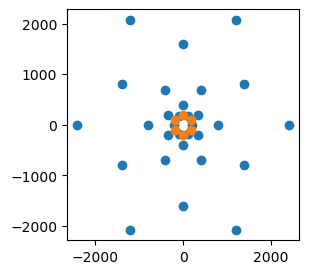

In [21]:
df =pd.DataFrame(bss_loc)
plt.figure(figsize=(3, 3))
plt.scatter(df[0],df[1])
df =pd.DataFrame(food_loc)
plt.scatter(df[0],df[1])
plt.show()

In [22]:
# 육각형 안에 있는지 판별
def discri(a):
    x=a[0]
    y=a[1]
    if (x>=0)&(y>=0): # 1사분면
        tf = (x/np.sqrt(3)+y<3000) & (x<3000)
    elif (x<0)&(y>0): # 2사분면
        tf = (-x/np.sqrt(3)+y<3000) & (x>-3000)
    elif (x<=0)&(y<=0): # 3사분면
        tf = (x>-3000) & (x/np.sqrt(3)+y>-3000)
    elif (x>0)&(y<0):
        tf = (-x/np.sqrt(3)+y>-3000) & (x<3000)
    return tf

# (x,y) 거리 구하기
def distance(x1,x2):
    return np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)
def masking(state):
    mask = np.zeros(2)
    # 오링안나기
    if state[2] < 0.12:
        mask[1] = -100
    # 50퍼 전에는 배달만
    if state[2] > 0.5:
        mask[0] = -100
    return mask

In [23]:
#일 종료

def end_day():
    global bike_df,day, bike, battery, bss, terminal
    day_acc_dist = []
    day_order_count = []
    day_charge_count = []
    for i in range(len(bike)):
        bike[i].cur_time=0
        bike_df[i].loc[day,'acc_dist'] = bike[i].acc_dist
        bike[i].acc_dist = 0
        bike_df[i].loc[day,'order_count'] = bike[i].order_count
        bike[i].order_count = 0
        bike_df[i].loc[day,'charge_count'] = bike[i].charge_count
        bike[i].charge_count = 0
        bike_df[i].loc[day,'total_queue_time'] = 0
        bike_df[i].loc[day,'moving_queue_time'] = 0
        bike_df[i].loc[day,'stay_queue_time'] = 0
        bike_df[i].loc[day,'queue_count'] = 0
        bike[i].bss_list = []
#         bike[i].reward=0
        bike[i].history = [[bike[i].status, 0, bike[i].loc, 0, bike[i].bat, 0, 0]]
        if len(bike[i].order_list)<2:
            bike[i].order_list = [[0,[0,0], [0,0], [0,0]],[0,[0,0], [0,0], [0,0]]]
        else:
            bike[i].order_list = [bike[i].order_list[-2],bike[i].order_list[-1]]
    idx = np.arange(0,len(bike))
    random.shuffle(idx)
    j=0
    for i in idx:
        bike[i].order_freq = freq[int(j)]
        j = j + len(freq)/len(bike)
    del idx    
#     soc_list=[]
    for i in range(len(battery)):
        battery[i].time=0
        if len(battery[i].bat_history)>0:
#             #[self.status, time,self.soc, self.bik, self.charge_count]
#             soc_list.append(battery[i].bat_history)
            battery[i].bat_history=[[0,0,0,0,0],battery[i].bat_history[-1]]
            battery[i].bat_history[-1][1] = 0
        battery[i].charge_count=0
#     soc_df.append(soc_list)  


    for i in range(len(bss)):
        if len(bss[i].bss_history)!=0:
            for j in range(len(bss[i].bss_history)):
                if (bss[i].bss_history[j][2] - bss[i].bss_history[j][1])>0:

                    bike_df[bss[i].bss_history[j][0]].loc[day,'queue_count'] += 1
#                     bike_df[bss[i].bss_history[j][0]].loc[day,'queue_time'] += bss[i].bss_history[j][2] - bss[i].bss_history[j][1]
    min_his_list=[]
    for i in range(len(bss)):
#         if terminal ==False:
        if len(bss[i].queue)>0:
            for j in range(len(bss[i].queue)):
                if (bss[i].queue[j][0]<43200)&(bss[i].queue[j][0]<time):
                    bike_df[bss[i].queue[j][1]].loc[day,'charge_count'] += 1
                    bike_df[bss[i].queue[j][1]].loc[day,'queue_count'] += 1
#                     bike_df[bss[i].queue[j][1]].loc[day,'queue_time'] += time - bss[i].queue[j][0]
                    arrived_time = bss[i].queue[j][0]
                    if int((time+60)/3600) == int(arrived_time/3600):
                        if arrived_time < 43200:
                            bike[bss[i].queue[j][1]].reward = bike[bss[i].queue[j][1]].reward - ((time - arrived_time)+60)*base_freq[int((time+60)/3600)]
                        else:
                            bike[bss[i].queue[j][1]].reward = 0
                    else:
                        if time+60 <= 43200:
                            bike[bss[i].queue[j][1]].reward = bike[bss[i].queue[j][1]].reward - (int((time+60)/3600)*3600-arrived_time)*base_freq[int(arrived_time/3600)] - (time - int((time+60)/3600)*3600)*base_freq[int((time+60)/3600)]
                        else:
                            bike[bss[i].queue[j][1]].reward = bike[bss[i].queue[j][1]].reward - (int((time+60)/3600)*3600-arrived_time)*base_freq[int(arrived_time/3600)-1] - (time - int((time+60)/3600)*3600)*base_freq[-1] 



                    bike[bss[i].queue[j][1]].stay_queue_time += time - bss[i].queue[j][0]

#                     cur_state=[]
#                     cur_state.append(0)
#                     cur_state.append(bike[bss[i].queue[j][1]].loc[0]/3000)
#                     cur_state.append(bike[bss[i].queue[j][1]].loc[1]/3000)
#                     cur_state.append(100/100)
#                     for k in range(len(bss)):
#                         cur_state.append(0)
#                     for k in range(len(bss)):
#                         for l in range(2,8,2):
#                             battery[bss[k].slot[l]].bat_charge()
#                             cur_state.append(100/100)
                    aa=False
                    if time> 43200:
                        aa = True
                    if time<43200:
                        if time - bss[i].queue[j][0] >3600:

                            aa = True
                            print('so long waited in ',bss[i].key)
                            print('day start to termianl : %.1f'%time)
                    else:
                        if 43200 - bss[i].queue[j][0] >3600:

                            aa = True
                            print('so long waited in ',bss[i].key)
                            print('day start to termianl : %.1f'%time)
                    if aa ==True:
                        update_memory(bike[bss[i].queue[j][1]].cur_state,bike[bss[i].queue[j][1]].action, bike[bss[i].queue[j][1]].reward, bike[bss[i].queue[j][1]].fu_state,50000)

                        model_fit()


                ##################################################################################
                    abc = battery[bike[bss[i].queue[j][1]].bat[0]].so
                    battery[bike[bss[i].queue[j][1]].bat[0]].so = battery[bike[bss[i].queue[j][1]].bat[0]].max_charge
                    battery[bike[bss[i].queue[j][1]].bat[0]].soc = 100

                    battery[bike[bss[i].queue[j][1]].bat[0]].bat_acc += battery[bike[bss[i].queue[j][1]].bat[0]].so-abc
                    battery[bike[bss[i].queue[j][1]].bat[0]].cycle= battery[bike[bss[i].queue[j][1]].bat[0]].bat_acc/100
#                     battery[bss[i].slot[k]].max_charge=100-(cycle_loss*battery[bss[i].slot[k]].cycle)
                    battery[bike[bss[i].queue[j][1]].bat[0]].bat_history=[[0,0,0,0,0],[battery[bike[bss[i].queue[j][1]].bat[0]].status, 0, battery[bike[bss[i].queue[j][1]].bat[0]].soc, battery[bike[bss[i].queue[j][1]].bat[0]].bik, battery[bike[bss[i].queue[j][1]].bat[0]].charge_count]]

                    abc = battery[bike[bss[i].queue[j][1]].bat[1]].so
                    battery[bike[bss[i].queue[j][1]].bat[1]].so = battery[bike[bss[i].queue[j][1]].bat[1]].max_charge
                    battery[bike[bss[i].queue[j][1]].bat[1]].soc = 100

                    battery[bike[bss[i].queue[j][1]].bat[1]].bat_acc += battery[bike[bss[i].queue[j][1]].bat[1]].so-abc
                    battery[bike[bss[i].queue[j][1]].bat[1]].cycle= battery[bike[bss[i].queue[j][1]].bat[1]].bat_acc/100
#                     battery[bss[i].slot[k]].max_charge=100-(cycle_loss*battery[bss[i].slot[k]].cycle)
                    battery[bike[bss[i].queue[j][1]].bat[1]].bat_history=[[0,0,0,0,0],[battery[bike[bss[i].queue[j][1]].bat[1]].status, 0, battery[bike[bss[i].queue[j][1]].bat[1]].soc, battery[bike[bss[i].queue[j][1]].bat[1]].bik, battery[bike[bss[i].queue[j][1]].bat[1]].charge_count]]
                ###############################################
        
    
        bss[i].bss_history = []
        min_his_list.append(bss[i].min_his)
        bss[i].min_his = []
    min_his_df.append(min_his_list)
    for i in range(len(bss)):
        bss[i].queue = []
    for i in range(len(bike)):
        bike_df[i].loc[day,'stay_queue_time'] = bike[i].stay_queue_time
        bike_df[i].loc[day,'moving_queue_time'] = bike[i].moving_queue_time
        bike_df[i].loc[day,'total_queue_time'] = bike[i].stay_queue_time + bike[i].moving_queue_time
        bike[i].stay_queue_time = 0
        bike[i].moving_queue_time = 0
    
    for i in range(len(bss)):
        for j in range(6):
            k = j+2
            abc = battery[bss[i].slot[k]].so
            
            battery[bss[i].slot[k]].so = battery[bss[i].slot[k]].max_charge
            battery[bss[i].slot[k]].soc = 100

            battery[bss[i].slot[k]].bat_acc += battery[bss[i].slot[k]].so-abc
            battery[bss[i].slot[k]].cycle= battery[bss[i].slot[k]].bat_acc/100
#             battery[bss[i].slot[k]].max_charge=100-(cycle_loss*battery[bss[i].slot[k]].cycle)
            battery[bss[i].slot[k]].bat_history=[[0,0,0,0,0],[battery[bss[i].slot[k]].status, 0, battery[bss[i].slot[k]].soc, battery[bss[i].slot[k]].bik, battery[bss[i].slot[k]].charge_count]]
            
def end_bike_n():

    # 바이크 90대 생성, 주문건수 할당

    #객체 90대 생성
    global bike
    bike = {}
    for i in range(int(bike_n)):
        bike[i] = Bike()
        bike[i].key = i
        bike[i].loc = (4000*random.random()-2000,4000*random.random()-2000)
#         bike[i].sooneung = sooneung_avg

    #base_freq, day_avg 따라 발생빈도 할당
    global freq
    freq = []
    for i in range(len(day_avg)):
        tmp = []
        for j in range(len(base_freq)):
            tmp.append(base_freq[j]*day_avg[i]/sum(base_freq))
        freq.append(copy.deepcopy(tmp))

    idx = np.arange(0,len(bike))
    random.shuffle(idx)
    j=0
    for i in idx:
        bike[i].order_freq = freq[int(j)]
        j = j + len(freq)/len(bike)

        bike[i].bat=[i*2,i*2+1]

    
    for i in range(len(bike)):
        if i / len(bike)<0.1:
            bike[i].charge_rule = char_rule[0]
        elif i/len(bike)<0.25:
            bike[i].charge_rule = char_rule[1]
        elif i/len(bike)<0.5:
            bike[i].charge_rule = char_rule[2]
        elif i/len(bike)<0.85:
            bike[i].charge_rule = char_rule[3]
        else:
            bike[i].charge_rule = char_rule[4]
       


    global battery
    battery = {}
    for i in range(int(bike_n)*2+bss_n*6):
        battery[i]=Battery()
        battery[i].key=i
    for i in range(len(bike)):
        battery[i*2].bik = i
        battery[i*2+1].bik = i
        
    if popul%10 ==0:
        for i in range(int(bike_n)):
            tmp = 100*random.random()+10
            if tmp >100:
                tmp = 100
    #         tmp = (popul%10)*10+10
            battery[i*2].so = tmp
            battery[i*2+1].so = tmp
            battery[i*2].soc = tmp
            battery[i*2+1].soc = tmp
    else:
        for i in range(20):
            battery[i*2].so = 10
            battery[i*2+1].so = 10
            battery[i*2].soc = 10
            battery[i*2+1].soc = 10
        for i in range(20,40):
            battery[i*2].so = 20
            battery[i*2+1].so = 20
            battery[i*2].soc = 20
            battery[i*2+1].soc = 20
        for i in range(40,60):
            battery[i*2].so = 30
            battery[i*2+1].so = 30
            battery[i*2].soc = 30
            battery[i*2+1].soc = 30
    
    #충전소 생성, 위치할당
    global bss
    bss = {}
    for i in range(bss_n):
        bss[i] = Bss()
        bss[i].key = i
        bss[i].slot[2] = i*6 + (2*len(bike))
        bss[i].slot[3] = i*6+1+ (2*len(bike))
        bss[i].slot[4] = i*6+2+ (2*len(bike))
        bss[i].slot[5] = i*6+3+ (2*len(bike))
        bss[i].slot[6] = i*6+4+ (2*len(bike))
        bss[i].slot[7] = i*6+5+ (2*len(bike))
        bss[i].loc = bss_loc[i]  

## 처음 돌릴 때

In [24]:
with tf.device('/device:CPU:0'):
    model.fit([np.array([np.ones(34)]),np.array([np.ones(120)]),np.array([np.ones(1)]),np.array([np.ones(2)])],[np.array([np.append(np.zeros(1),0)])], verbose=0)
    model.fit([np.array([np.ones(34)]),np.array([np.ones(120)]),np.array([np.ones(1)]),np.array([np.ones(2)])],[np.array([np.append(np.zeros(1),0)])], verbose=0)
    model.fit([np.array([np.ones(34)]),np.array([np.ones(120)]),np.array([np.ones(1)]),np.array([np.ones(2)])],[np.array([np.append(np.zeros(1),0)])], verbose=0)
    model.fit([np.array([np.ones(34)]),np.array([np.ones(120)]),np.array([np.ones(1)]),np.array([np.ones(2)])],[np.array([np.append(np.zeros(1),0)])], verbose=0)
    model.fit([np.array([np.ones(34)]),np.array([np.ones(120)]),np.array([np.ones(1)]),np.array([np.ones(2)])],[np.array([np.append(np.zeros(1),0)])], verbose=0)
    model2.set_weights(model.get_weights())

In [25]:
# for i in range(10000000):
#     model.fit([np.array([np.ones(34)]),np.array([np.ones(120)]),np.array([np.ones(1)]),np.array([np.ones(2)])],[np.array([np.append(np.zeros(1),0)])], verbose=0, use_multiprocessing=False)

In [26]:
event_list=[]
state = []
fubike_idx=0
D_memory=[]
# D_terminal=[]

In [27]:
from tensorflow.keras.models import load_model

model.load_weights('best_model(action2_multi)(300).h5')
model2.set_weights(model.get_weights())

In [28]:
# tmp_list = []
# for i in range(10000):
#     tmp_list.append([int(random.random()*10000)])
#     tmp_list.append([int(random.random()*10000)])
#     tmp_list.append([int(random.random()*10000)])

In [29]:
# s = tim.time()
# for i in range(300):
#     a = sorted(tmp_list)
# print(tim.time() - s)

In [30]:
# 이어서 돌릴 때 주석해제하고 돌리기

with open('initial_states.pickle', 'rb') as f:
    initial_states = pickle.load(f)

# with open('D_memory(210).pickle', 'rb') as f:
#     D_memory = pickle.load(f)

# tmp1=[]
# tmp2=[]
# tmp3=[]
# temp=[]
# delt=[]
# mask1=[]
# for i in range(len(D_memory)):
#     train = D_memory[i]
    
#     tmp1.append(train[0][0:34])
#     tmp2.append(train[0][34:154])
#     tmp3.append(train[0][154:254])
#     mask1.append([masking(train[0])])

#     tmp=[]
#     tmp.append(np.array([train[3][0:34]]))
#     tmp.append(np.array([train[3][34:154]]))
#     tmp.append(np.array([train[3][154:254]]))
#     mask = masking(train[3])
#     tmp.append(np.array([mask]))


#     predicted1 = model2.predict(tmp)[0][np.argmax(model.predict(tmp).copy())]

#     tmp_max = qrate*predicted1

#     tmp=np.zeros(2)
#     tmp[train[1]]=1.0

#     temp.append(tmp)
#     delt.append(train[2] + tmp_max*(1-train[4]))



#     tmp=[]
#     tmp.append(np.array([train[0][0:34]]))
#     tmp.append(np.array([train[0][34:154]]))
#     tmp.append(np.array([train[0][154:254]]))
#     mask = masking(train[0])
#     tmp.append(np.array([mask]))

                
#     TD_error_list = np.append(TD_error_list,np.abs(delt[-1]-model.predict(tmp)[0][train[1]])+TD_max/D_size)

# TD_index = np.arange(0,len(TD_error_list))

# TD_max = np.max(TD_error_list[:int(len(TD_error_list))])
# max_w_i = (len(D_memory)*TD_max/np.sum(TD_error_list))**(-beta)


# # with open('D_terminal.pickle', 'rb') as f:
# #     D_terminal = pickle.load(f)

In [31]:
model2.set_weights(model.get_weights())


episode 0
day : 0


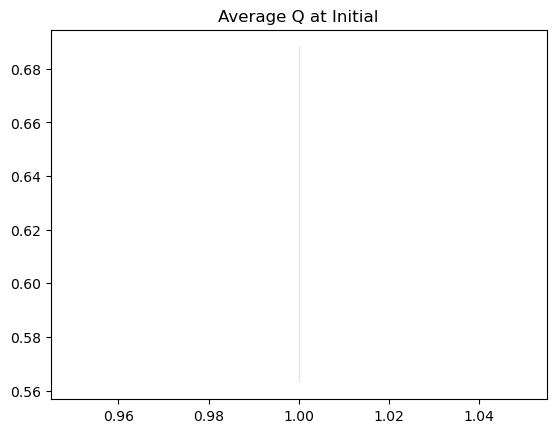

model updated

 time for simulate one day : 259.5

average moving queuetime :  55.6 115.9
average stay queuetime :  0.5 0.9
average total queuetime :  56.1 116.8
average chargecount :  2.1 2.1
average ordercount :  39.1 39.1
day : 1


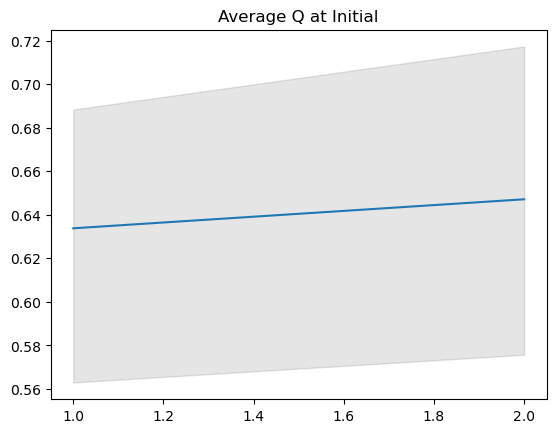

model updated

 time for simulate one day : 272.2

average moving queuetime :  63.7 144.8
average stay queuetime :  1.7 6.0
average total queuetime :  65.4 150.7
average chargecount :  2.0 2.0
average ordercount :  38.9 38.8
day : 2


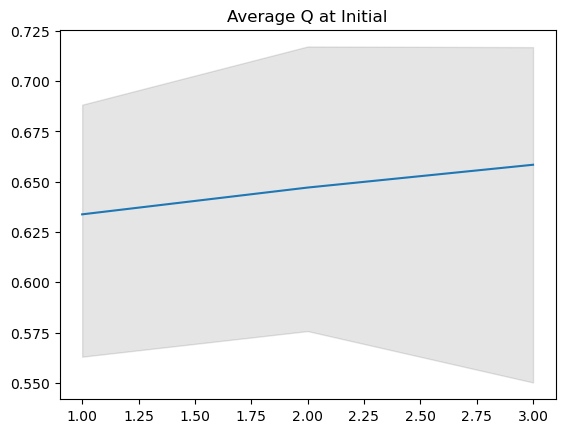

model updated

 time for simulate one day : 278.8

average moving queuetime :  69.4 167.5
average stay queuetime :  4.9 23.4
average total queuetime :  74.3 190.9
average chargecount :  2.1 2.1
average ordercount :  38.9 38.8
day : 3


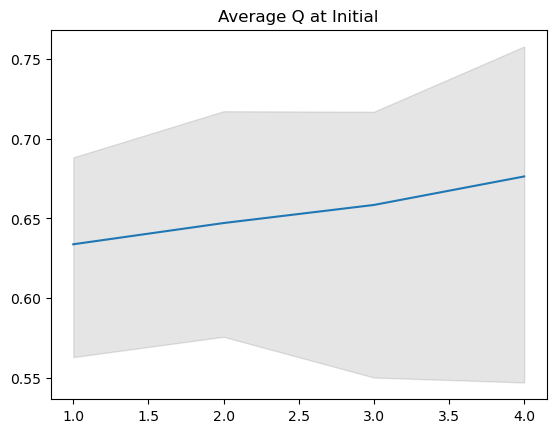

model updated


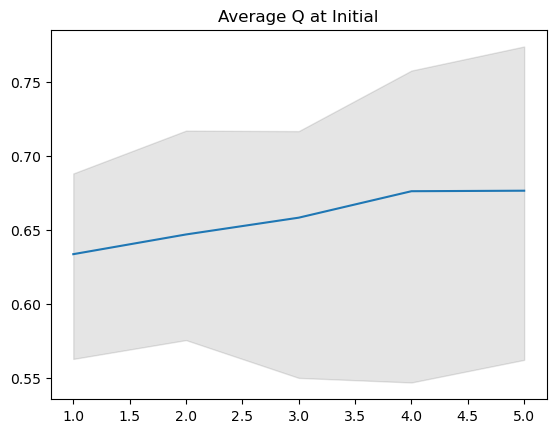

model updated

 time for simulate one day : 285.2

average moving queuetime :  69.8 152.8
average stay queuetime :  6.0 19.5
average total queuetime :  75.8 172.3
average chargecount :  2.1 2.2
average ordercount :  38.9 38.9
day : 4
so long waited in  23
day start to termianl : 4065.0

 time for simulate one day : 18.1
so long waited in  16
day start to termianl : 4065.0
so long waited in  22
day start to termianl : 4065.0

average moving queuetime :  71.1 35.6
average stay queuetime :  18.6 111.2
average total queuetime :  89.7 146.9
average chargecount :  1.7 0.3
average ordercount :  31.4 1.3
[89, 35, 38, 36, 33, 54, 70, 62, 63, 56, 46, 43]
[90, 40, 18, 36, 17, 73, 66, 59, 52, 48, 55, 49]
[92, 44, 16, 30, 39, 58, 69, 48, 58, 66, 64, 39]
[91, 57, 47, 35, 33, 42, 68, 39, 60, 67, 74, 33]
[98, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 13, 12, 10, 8, 7, 7, 10, 16, 16, 9, 4]
cycle :  5.991188745179891
code start to now : 1117.1
episode_reward :  1537.7160412652827
fit_count :  51759
TD max = 

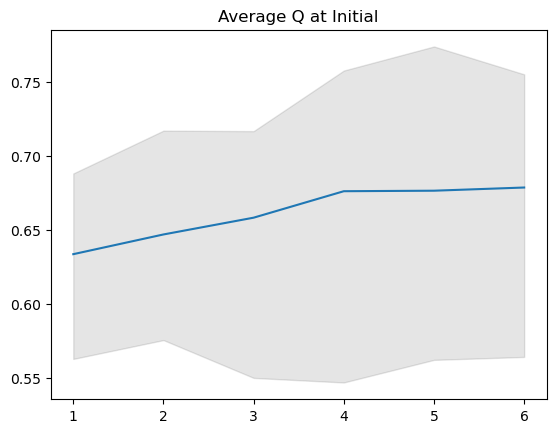

model updated


In [ ]:
star = tim.time()
for popul in range(100000):
    
#     fit_count = 0
    start = tim.time()
    print('\nepisode',popul)
    episode_reward = 0

    

    terminal = False
    tmp_terminal = False
    
    end_bike_n()
    bike_df = []
    for i in range(int(bike_n)):
        bike_df.append(pd.DataFrame(columns=['order_count', 'acc_dist', 'charge_count', 'queue_count', 'moving_queue_time', 'stay_queue_time','total_queue_time']))
    min_his_df = []
    soc_df = []
    #[self.key, bike_idx, self.queue[0][1], time - self.queue[0][1]]


    end_bike_n()

    day=0

    while terminal == False:
        sta = tim.time()
        
        print('day :',day)
        
        time = 0
        event_list=[]

        for i in range(len(bike)):
            event_list.append([0, bike[i], 'decide'])
        
        event_list = sorted(event_list)
        while len(event_list)>0:

            time = event_list[0][0]
            # if time
            if len(event_list[0])<4:
                getattr(event_list[0][1],event_list[0][2])()
            elif len(event_list[0])==4:
                getattr(event_list[0][1],event_list[0][2])(event_list[0][3])
            else:
                print('event_list length error')
            if terminal == True:
                break
#             time = event_list[0][0]

        print('\n time for simulate one day : %.1f'%(tim.time()-sta))
            

        end_day()
        tmp_df = copy.deepcopy(bike_df[0])
        for i in range(1,len(bike_df)):
            tmp_df +=bike_df[i]
        tmp_df = tmp_df/len(bike_df)
        tmp_chargecount = np.mean(tmp_df.iloc[:,2])
        tmp_queuetime1 = np.mean(tmp_df.iloc[:,4])
        tmp_queuetime2 = np.mean(tmp_df.iloc[:,5])
        tmp_queuetime3 = np.mean(tmp_df.iloc[:,6])
        tmp_ordercount = np.mean(tmp_df.iloc[:,0])
        print('\naverage moving queuetime : ',round(tmp_queuetime1/tmp_chargecount,1),round(tmp_df.iloc[-1,4],1))
        print('average stay queuetime : ',round(tmp_queuetime2/tmp_chargecount,1),round(tmp_df.iloc[-1,5],1))
        print('average total queuetime : ',round(tmp_queuetime3/tmp_chargecount,1),round(tmp_df.iloc[-1,6],1))
        print('average chargecount : ',round(tmp_chargecount,1),round(tmp_df.iloc[-1,2],1))
        print('average ordercount : ',round(tmp_ordercount,1),round(tmp_df.iloc[-1,0],1))
        del event_list
        if day == int(day_n):
            terminal = True
            tmp_terminal = True
        day += 1
            

#     with open(str(int(bike_n))+'bike'+str(int(day_n))+'days.pickle', 'wb') as f:
#         pickle.dump(bike_df, f)
#     with open(str(int(bike_n))+'min_his'+str(int(day_n))+'days.pickle', 'wb') as f:
#         pickle.dump(min_his_df, f)
#     with open(r'C:\Users\ysp\Dropbox\python_code\zentropy\algo5\\'+str(bike_n)+'soc_his'+str(day_n)+'days.pickle', 'wb') as f:
#         pickle.dump(soc_df, f)
    for i in range(len(min_his_df)):
        tmp_data = min_his_df[i]
        count = [0,0,0,0,0,0,0,0,0,0,0,0]
        for j in range(len(tmp_data)):
            for k in range(len(tmp_data[j])):
                if int(tmp_data[j][k][3]//3600) >11:
                    count[-1] +=1
                else:
                    count[int(tmp_data[j][k][3]//3600)] += 1
        print(count)
    print([4,13,12,10,8,7,7,10,16,16,9,4])        
    cycle_sum = []
    for i in range(len(battery)):
        cycle_sum.append(battery[i].cycle)
    print('cycle : ',np.mean(cycle_sum))
    stop = tim.time()  
    print('code start to now : %.1f'%(stop - star))
    print('episode_reward : ', episode_reward)
    print('fit_count : ',fit_count)
    print('TD max =', np.max(TD_error_list), 'TD min =', np.min(TD_error_list))
    exploration_rate = 0.1-fit_count/10000000
    TD_max = np.max(TD_error_list[:int(9*len(TD_error_list)/10)])
    max_w_i = (len(D_memory)*TD_max/np.sum(TD_error_list))**(-beta)
    
    if bike_n < 300:
        bike_n += 1
    if episode_reward > best_episode_reward:
        best_episode_reward = episode_reward
#         model.save('best_model(230).h5')
        model.save_weights("best_model(action2_multi)(300).h5")
        print('best model updated')
        if episode_reward > 300:
            day_n += 0.25
#             bike_n+=0.5
    if day_n > 30:
        day_n = 30
#     if bike_n >230:
#         bike_n=230


#     fit_count += 1
#         model2 = load_model('best_model.h5')
#         model2.compile(optimizer='rmsprop',loss=['mse'])
    if fit_count > 1000000:
        print('model updated')
        model2.set_weights(model.get_weights())

#     with open('D_often.pickle', 'wb') as f:
#         pickle.dump(D_often, f)
#     with open('D_sparse.pickle', 'wb') as f:
#         pickle.dump(D_sparse, f)


In [ ]:
# 아래는 결과확인 위한 잡코드

In [ ]:
maps = [[0,0,1,0,0],[0,1,1,0,1],[0,0,1,0,1],[1,1,1,0,1]]
answer = 16
as_1D=[]
for i in maps:
    as_1D += i
# print(as_1D)
part = []
k=0
for i in range(len(maps)):
    for j in range(len(maps[i])):
        if maps[i][j] ==1:
            part.append([i,j,k])
            k += 1
print(part)
linked_part = []
for i in range(len(part)):
    linked_part.append([])
for i in range(len(part)):
    for j in range(i+1,len(part)):
        if (part[i][0] == part[j][0])|(part[i][1] == part[j][1]):
            linked_part[i].append(part[j])
print(linked_part)
islands_num=[]
islands=[]
for i in range(len(part)):
    for j in range(len(part[i])):
        for k in range(len(islands_num)):
            if i in islands_num[k]:
                for l in range(len(linked_part[i])):
                    islands_num[k].append(linked_part[i][l][2])
                    islands[k].append(linked_part[i][l])
            else:
                islands_num.append(part[i][2])
                islands.append(part[i])
        if len(islands_num)==0:
            islands_num.append(part[i][2])
            islands.append(part[i])

In [ ]:
islands_num = []
for i in range(len(islands_num)):
    print(islands_num[i])

In [ ]:
for i in range(len(D_memory)):
    print(D_memory[i][1])

In [ ]:
TD_max/np.sum(TD_error_list)

In [ ]:
len(TD_index)

In [ ]:
len(TD_error_list)

In [ ]:
for i in range(len(TD_error_list)):
    print(TD_error_list[i])

In [ ]:
len(TD_error_list)

In [ ]:
random.sample([1,2,3,4], counts=[30,10,1,1], k=3)

In [ ]:
for i in range(10):
    TD_index = np.arange(0,len(TD_error_list))
    choice = random.choices(TD_index, weights = TD_error_list)[0]
    print(choice)
    train = D_memory[choice]

    tmp=[]
    tmp.append(np.array([train[0][0:34]]))
    tmp.append(np.array([train[0][34:154]]))
    tmp.append(np.array([train[0][154:184]]))
    mask = masking(train[0])
    tmp.append(np.array([mask]))
    predicted1 = model.predict(tmp).copy()
    print('battery: ',train[0][2],'action: ',train[1],'reward: ', train[2])
    print(predicted1)
    print(train[0][34:64])

In [ ]:
TD_index = np.arange(0,len(TD_error_list))
choice = random.choices(TD_index, weights = TD_error_list)[0]
print(choice)
train = D_memory[choice]

tmp=[]
tmp.append(np.array([train[3][0:64]]))
tmp.append(np.array([train[3][64:154]]))
tmp.append(np.array([train[3][154:184]]))

In [ ]:
train[3][2]

In [ ]:
train[3][35]

In [ ]:
mask = np.ones(31)
if train[3][2] < 0.05:
    mask[30] = 0
for i in range(30):
    if train[3][34+i] > 1:
        mask[i] = 0

In [ ]:
mask

In [ ]:
tmp

In [ ]:
len(TD_error_list)

In [ ]:
len(TD_index)

In [ ]:
model = load_model('current_model.h5')
model.compile(optimizer = 'rmsprop', loss='mse', metrics=['mae','mse'])

## 이어하기

In [ ]:
model = load_model('current_model.h5')
model.compile(optimizer='rmsprop',loss=['mse','mse'])

In [ ]:


star = tim.time()
for popul in range(100000):
    start = tim.time()
    print('\nepisode',popul)

    

    terminal = False
    
    end_bike_n()
    bike_df = []
    for i in range(bike_n):
        bike_df.append(pd.DataFrame(columns=['order_count', 'acc_dist', 'charge_count', 'queue_count', 'queue_time'], index = np.arange(0,day_n)).fillna(0))
    min_his_df = []
    soc_df = []
    #[self.key, bike_idx, self.queue[0][1], time - self.queue[0][1]]


    end_bike_n()

    day=0
    while terminal == False:
        sta = tim.time()
        
        print('day :',day)
        day += 1
        time = 0
        event_list=[]

        for i in range(len(bike)):
            event_list.append([0, bike[i], 'decide'])
        model.save('current_model.h5')
 
        model2 = model
        while time<43200:
            event_list = sorted(event_list)
        

            time = event_list[0][0]
            if len(event_list[0])<4:
                getattr(event_list[0][1],event_list[0][2])()
            elif len(event_list[0])==4:
                getattr(event_list[0][1],event_list[0][2])(event_list[0][3])
            else:
                print('event_list length error')
            if terminal == True:
                break
        print('\n time for simulate one day : ',tim.time()-sta)
            

        end_day()
        del event_list
        if day == day_n:
            terminal = True
            
    tmp_df = bike_df[0]
    for i in range(1,len(bike_df)):
        tmp_df +=bike_df[i]
    tmp_df = tmp_df/len(bike_df)
    tmp_chargecount = np.mean(tmp_df.iloc[:,2])
    tmp_queuetime = np.mean(tmp_df.iloc[:,4])
    print('average queuetime : ',tmp_queuetime)
    print('average chargecount : ',tmp_chargecount)

    with open(str(bike_n)+'bike'+str(day_n)+'days.pickle', 'wb') as f:
        pickle.dump(bike_df, f)
    with open(str(bike_n)+'min_his'+str(day_n)+'days.pickle', 'wb') as f:
        pickle.dump(min_his_df, f)
#     with open(r'C:\Users\ysp\Dropbox\python_code\zentropy\algo5\\'+str(bike_n)+'soc_his'+str(day_n)+'days.pickle', 'wb') as f:
#         pickle.dump(soc_df, f)
        
    cycle_sum = []
    for i in range(len(battery)):
        cycle_sum.append(battery[i].cycle)
    print('cycle : ',np.mean(cycle_sum))
    stop = tim.time()  
    print('code start to terminal : %.1f'%(stop - star))





In [ ]:
from keras.models import load_model

In [ ]:
model.summary()